# Objective - Wound Classifier using CNN
# It is multi  - Class - Classification (10)
# Increase the Accuracy from 50% to 80% (Train and Test/Validation)

# 1 . Import Python Pacakges

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense, MaxPooling2D,Conv2D
from keras.layers import Input,Activation,Add
from keras.models import Model
from keras.regularizers import l2

import cv2
from sklearn.metrics import confusion_matrix
from PIL import Image
import pickle

C:\Users\91956\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 2. Read the dataset - doing the Initial Inspection

In [2]:
dataset_path = r"WoundDataset"

def load_dataset(dataset_path):

    data = {'Path': [], 'Class': []}

    entries = os.listdir(dataset_path)

    for entry in entries:
        full_path = os.path.join(dataset_path, entry)
        if os.path.isdir(full_path):
            files = os.listdir(full_path)
            for file in files:
                file_path = os.path.join(full_path, file)

                data['Path'].append(file_path)
                data['Class'].append(entry)

    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10, 6))
    plt.grid()
    sns.countplot(data=df, x='Class')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()
    return df

# 3. Process the Data Set

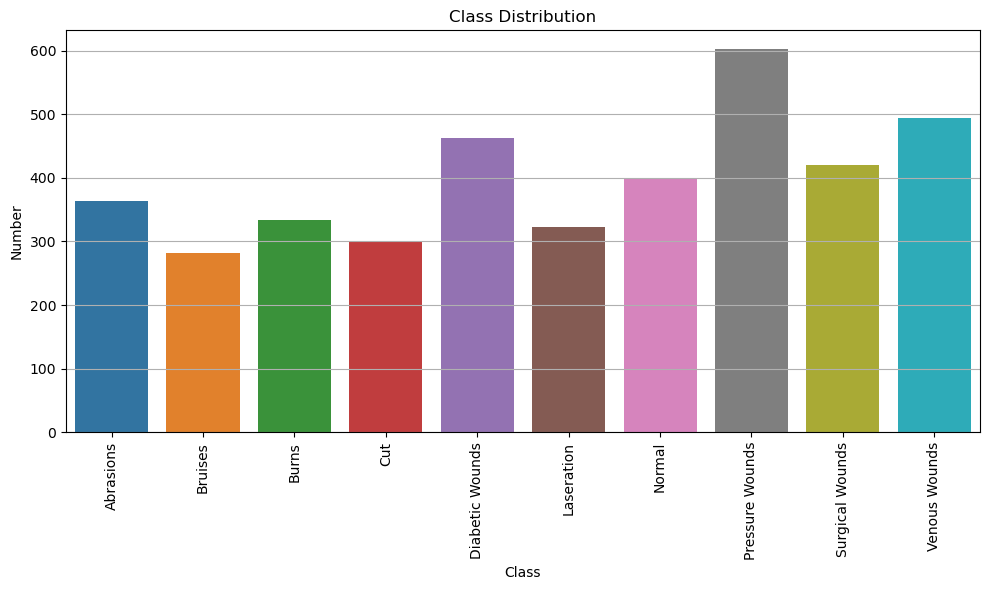

In [3]:
df = load_dataset(dataset_path)
label_encoder = LabelEncoder()
df['labels_encoded'] = label_encoder.fit_transform(df['Class'])


train_paths, test_paths, train_labels, test_labels = train_test_split(
    df['Path'], df['labels_encoded'], test_size=0.3, random_state=42
)


def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust the size as needed
    image = image/255
    return image

train_images = np.array([preprocess_image(path) for path in train_paths])
test_images = np.array([preprocess_image(path) for path in test_paths])


In [4]:
print("Number of training samples:", len(train_paths))
print("Number of testing samples:", len(test_paths))

Number of training samples: 2786
Number of testing samples: 1194


# 4. CNN - Model Creation

In [5]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224, 3)), 
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [12]:
model = tf.keras.Sequential([
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)     

# 5. Model Compile & fit

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50
history = model.fit(train_images,train_labels,batch_size=32, validation_data=(test_images, test_labels) ,epochs=epochs)




Epoch 1/50


88/88 [==============================] - 68s 740ms/step - loss: 2.2590 - accuracy: 0.2057 - val_loss: 2.0770 - val_accuracy: 0.2412
Epoch 2/50
88/88 [==============================] - 60s 684ms/step - loss: 1.8187 - accuracy: 0.3604 - val_loss: 1.8622 - val_accuracy: 0.3811
Epoch 3/50
88/88 [==============================] - 59s 672ms/step - loss: 1.5884 - accuracy: 0.4383 - val_loss: 1.5017 - val_accuracy: 0.4824
Epoch 4/50
88/88 [==============================] - 59s 668ms/step - loss: 1.4897 - accuracy: 0.4856 - val_loss: 1.5368 - val_accuracy: 0.4891
Epoch 5/50
88/88 [==============================] - 59s 670ms/step - loss: 1.4061 - accuracy: 0.5115 - val_loss: 1.5589 - val_accuracy: 0.4799
Epoch 6/50
88/88 [==============================] - 63s 712ms/step - loss: 1.2829 - accuracy: 0.5488 - val_loss: 1.4459 - val_accuracy: 0.5360
Epoch 7/50
88/88 [==============================] - 60s 685ms/step - loss: 1.1798 - accuracy: 0.5811 - val_loss: 1.2444 - val_accuracy: 0.5

# 6 Model Performance - Save

In [14]:
model.evaluate(test_images, test_labels)

38/38 [==============================] - 6s 146ms/step - loss: 0.9390 - accuracy: 0.8492


[0.9389552474021912, 0.8492462038993835]

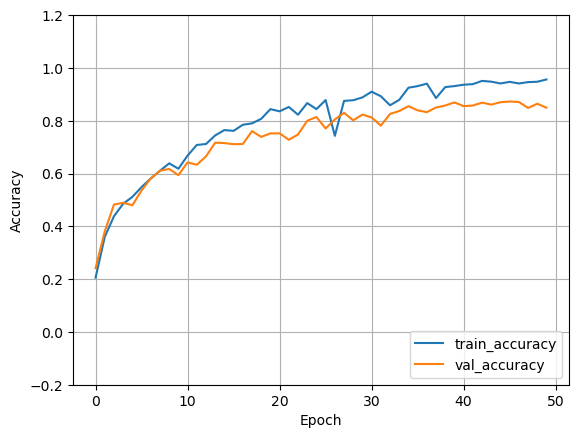

In [21]:
import matplotlib.pyplot as plt
plt.grid()
plt.plot(history.history['accuracy'], label='train_accuracy')
#plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
#plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-0.2, 1.2])
plt.legend(loc='lower right')
plt.show()

In [22]:
model.save('my_model.h5')

In [17]:
class_names=df['Class'].unique()
class_names

array(['Abrasions', 'Bruises', 'Burns', 'Cut', 'Diabetic Wounds',
       'Laseration', 'Normal', 'Pressure Wounds', 'Surgical Wounds',
       'Venous Wounds'], dtype=object)

In [18]:
from sklearn.metrics import classification_report
y_pred_prob = model.predict(test_images)  # Predicted probabilities for each class
y_pred = y_pred_prob.argmax(axis=1)  # Convert probabilities to class labels

# Generate classification report
report = classification_report(test_labels, y_pred, target_names=class_names)

print(report)

38/38 [==============================] - 6s 145ms/step
                 precision    recall  f1-score   support

      Abrasions       0.80      0.76      0.78       124
        Bruises       0.80      0.76      0.78        87
          Burns       0.80      0.86      0.83        98
            Cut       0.89      0.83      0.86        95
Diabetic Wounds       0.88      0.76      0.82       134
     Laseration       0.76      0.95      0.84        97
         Normal       0.93      0.99      0.96       126
Pressure Wounds       0.89      0.87      0.88       163
Surgical Wounds       0.88      0.83      0.85       122
  Venous Wounds       0.84      0.87      0.85       148

       accuracy                           0.85      1194
      macro avg       0.85      0.85      0.84      1194
   weighted avg       0.85      0.85      0.85      1194



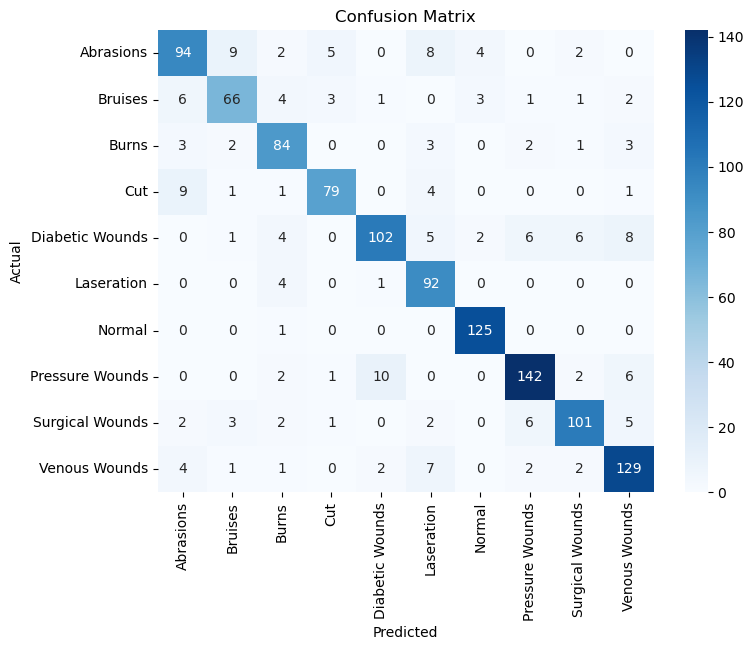

In [19]:
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [6]:
model_2 = tf.keras.Sequential([
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='sigmoid'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3),padding='same', activation='sigmoid'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3),padding='same', activation='sigmoid'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)     

In [7]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 20
history_1 = model_2.fit(train_images,train_labels,batch_size=32, validation_data=(test_images, test_labels) ,epochs=epochs)


Epoch 1/20


88/88 [==============================] - 73s 807ms/step - loss: 2.6351 - accuracy: 0.1267 - val_loss: 2.2952 - val_accuracy: 0.1365
Epoch 2/20
88/88 [==============================] - 71s 804ms/step - loss: 2.2805 - accuracy: 0.1547 - val_loss: 2.2980 - val_accuracy: 0.1365
Epoch 3/20
88/88 [==============================] - 71s 805ms/step - loss: 2.2799 - accuracy: 0.1576 - val_loss: 2.2911 - val_accuracy: 0.1365
Epoch 4/20
88/88 [==============================] - 71s 807ms/step - loss: 2.2771 - accuracy: 0.1576 - val_loss: 2.2979 - val_accuracy: 0.1365
Epoch 5/20
88/88 [==============================] - 71s 805ms/step - loss: 2.2806 - accuracy: 0.1508 - val_loss: 2.2877 - val_accuracy: 0.1365
Epoch 6/20
88/88 [==============================] - 72s 823ms/step - loss: 2.2799 - accuracy: 0.1543 - val_loss: 2.2914 - val_accuracy: 0.1365
Epoch 7/20
88/88 [==============================] - 70s 801ms/step - loss: 2.2800 - accuracy: 0.1515 - val_loss: 2.2855 - val_accuracy: 0.1

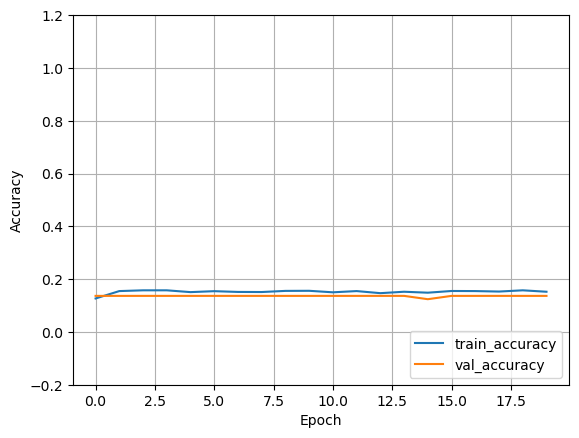

In [8]:
import matplotlib.pyplot as plt
plt.grid()
plt.plot(history_1.history['accuracy'], label='train_accuracy')
#plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history_1.history['val_accuracy'], label='val_accuracy')
#plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-0.2, 1.2])
plt.legend(loc='lower right')
plt.show()